In [ ]:
"""Downloading and extracting the data from Kaggle"""

#!pip install kaggle #requirement already satisfied so you can skip it next time

#create a .kaggle directory
!mkdir ~/.kaggle

#copy the kaggle json file to the current instance folder
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

#download the dataset
!kaggle competitions download dogs-vs-cats

#you could also use ! kaggle datasets download <name-of-dataset> if the dataset is not in any competition competition /c/

#unzipping the training and testing folders
!unzip test1.zip
!unzip train.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/dog.5499.jpg      
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       

In [ ]:
#Importing the relevant libraries: Pytorch, OS, PIL, Numpy, Matplotlib
import torchsummary
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torchvision
from torchvision import transforms as T
import torch.optim as optim
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from glob import glob
from tqdm import tqdm
from shutil import copy, move
import random

In [ ]:
#Inspecting the training and testing directories
root = "/content"
train_path = os.listdir(os.path.join(root, "train"))
test_path = os.listdir(os.path.join(root, "test1"))

print("The training set has {} images\n".format(len(train_path)))
print("The test set has {} images".format(len(test_path)))


dog_images = glob(os.path.join(root, "train", "dog*jpg"))
cat_images = glob(os.path.join(root, "train", "cat*jpg"))

print("\nThere are {} dog images and {} cat images. ".format(len(dog_images), len(cat_images)))

The training set has 25000 images

The test set has 12500 images

There are 12500 dog images and 12500 cat images. 


In [ ]:
#The dataset is made up of cat and dog images labelled by way of their file names. The dataset is divided into training and validation sets
train_path = "./training"
val_path = "./validation"
test_path = "/content/test1"

path_list = [train_path, val_path]

for path in path_list:
  os.makedirs(path, exist_ok=True)

In [ ]:
#Splitting the dataset into test and validation sets 
from sklearn.model_selection import train_test_split
dog_train_set, dog_val_set = train_test_split(dog_images, test_size = 0.1, shuffle = True, random_state = 10)
cat_train_set, cat_val_set = train_test_split(cat_images, test_size = 0.1, shuffle = True, random_state = 10)

#Copying the data into their respective destinations
for name in tqdm(dog_train_set):
  copy(name, os.path.join(train_path, name.split('/')[-1]))

for name in tqdm(dog_val_set):
  copy(name, os.path.join(val_path, name.split('/')[-1]))

for name in tqdm(cat_val_set):
  copy(name, os.path.join(val_path, name.split('/')[-1]))

for name in tqdm(cat_train_set):
  copy(name, os.path.join(train_path, name.split('/')[-1]))

for path in path_list:
  print("\nThe length of {} is {} ".format(path ,len(os.listdir(path))))

100%|██████████| 11250/11250 [00:01<00:00, 8428.52it/s]


The length of ./training is 22500 

The length of ./validation is 2500 


In [ ]:
#Creating a class that loads the dataset from the directories
class DogvsCatDataset(torch.utils.data.Dataset):
  def __init__(self, path, train = True, transforms = None):
    self.path = path
    self.transforms = transforms
    self.images = list(sorted(os.listdir(path)))
    self.labelDict = {"cat": 0, "dog": 1}
  
  def __getitem__(self, index):
    image_path = os.path.join(self.path, self.images[index])
    image = Image.open(image_path).convert("RGB")
    if train == False:
      if self.transforms is not None:
        image = self.transforms(image)

      return image
      
    label = self.labelDict[self.images[index].split(".")[0]]

    if self.transforms is not None:
      image = self.transforms(image)

    return image, label

  def __len__(self):
    return len(self.images)


#Create the transforms that will with which the data will be preprocessed
img_transforms = T.Compose([T.Resize((224,224)),
                            T.ToTensor(),
                            T.Normalize([0.485, 0.456, 0.406],
                                        [0.229, 0.224, 0.225])])



In [ ]:
#Creating the data sets and the various data loaders
batch_size=32
num_of_workers = 0
train_dataset = DogvsCatDataset(train_path, transforms=img_transforms)
val_dataset = DogvsCatDataset(val_path, transforms=img_transforms)
test_dataset = DogvsCatDataset(test_path, train = False, transforms=img_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_of_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_of_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_of_workers, shuffle=False)

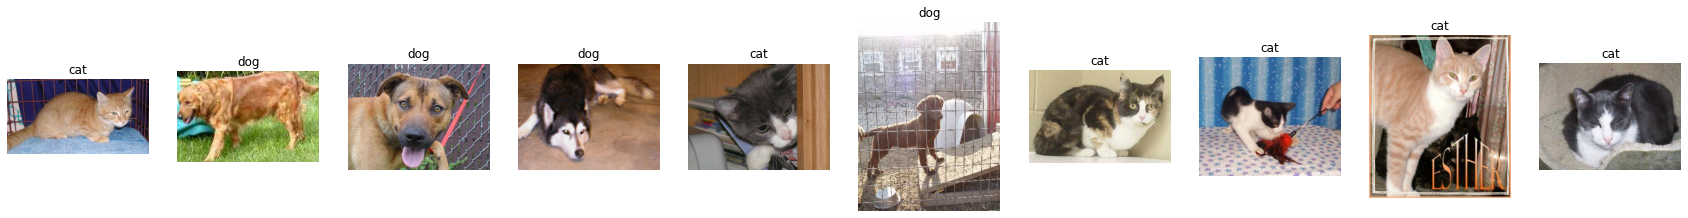

In [ ]:
#Plotting some images some the training folder
#Shuffling the images in the directory
images_folder = os.listdir('/content/training')
random.shuffle(images_folder)
full_image_paths = []
for image in images_folder:
  full_image_paths.append(os.path.join("/content/training", image))

#plotting the first 10 images 
fig, axes = plt.subplots(1, 10, figsize = (30, 10))
for img, ax in zip(full_image_paths[:10], axes):
  label = img.split('/')[-1].split('.')[0]
  img = mpimg.imread(img)
  ax.imshow(img)
  ax.set_title(label)
  ax.axis('Off')
plt.show()



In [ ]:
#Building the Model
# Creating a CNN class
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv_layer4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv_layer5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.fc1 = nn.Linear(179776, 256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        
        self.fc3 = nn.Linear(128, num_classes)
    
    # Progresses data across layers    
    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.max_pool1(x)
        
        x = self.conv_layer4(x)
        x = self.conv_layer5(x)
        x = self.batchnorm2(x)
        x = self.max_pool2(x)
                
        x = x.reshape(x.size(0), -1)
        
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        output = self.fc3(x)

        return output

In [ ]:
num_of_classes = 2
model = CNN(num_of_classes)
model

CNN(
  (conv_layer1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv_layer2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_layer4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv_layer5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=179776, out_features=256, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)

In [ ]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

46121762

In [ ]:
#Checking the device for computation
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

criterion =  nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay= 0.0001)

num_of_epochs = 7
device

device(type='cuda')

In [ ]:
# Function to test the model with the test dataset and print the accuracy for the test images
def calcAccuracy(loader):
    
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in loader:
            images, labels = data
            
            images = images.to(device)
            labels = labels.to(device)
            
            # Making predictions, aggregating them and calculating the accuracy
            output = model(images)
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return(accuracy)


# Defining the training function
def train(num_epochs, criterion, train_loader):

    # Define your device and move the model to the device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on ", device, " device")
    model.to(device)

    for epoch in tqdm(range(num_epochs)):  
        running_loss = 0.0
        running_acc = 0.0

        for i, (images, labels) in enumerate(train_loader, 0):
            
            # We move the inputs to the right device
            images = images.to(device)
            labels = labels.to(device)

            # The gradients accumulate, hence we need to zero them out 
            optimizer.zero_grad()
            # We propagate our images through the model and get the predictions
            outputs = model(images)

            # Here, we calculate the value of the loss function based on our labels and predictions, calculate our gradients and propagate these back through the network
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # extract the loss value
            running_loss += loss.item()     
            if i % 100 == 99:    
                # print every 1000 (twice per epoch) 
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                # zero the loss
                running_loss = 0.0

        # Compute and print the average accuracy over both the training set and validation set
        accuracy = calcAccuracy(train_loader)
        val_accuracy = calcAccuracy(val_loader)
        print('For epoch {}, the accuracy over the training set is {:.3f}%'.format(epoch+1, accuracy))
        print('For epoch {}, the accuracy over the validation set is {:.3f}%'.format(epoch+1, val_accuracy))

        

In [ ]:
]\# Let's build our model
train(num_of_epochs, criterion, train_loader)
print('Finished Training')


The model will be running on  cuda:0  device


  0%|          | 0/7 [00:00<?, ?it/s]

[1,   100] loss: 2.036
[1,   200] loss: 0.803
[1,   300] loss: 0.683
[1,   400] loss: 0.663
[1,   500] loss: 0.649
[1,   600] loss: 0.649
[1,   700] loss: 0.639


 14%|█▍        | 1/7 [04:33<27:18, 273.04s/it]

For epoch 1, the accuracy over the training set is 65.173%
For epoch 1, the accuracy over the validation set is 64.200%
[2,   100] loss: 0.634
[2,   200] loss: 0.622
[2,   300] loss: 0.608
[2,   400] loss: 0.611
[2,   500] loss: 0.602
[2,   600] loss: 0.600
[2,   700] loss: 0.596


 29%|██▊       | 2/7 [09:03<22:38, 271.73s/it]

For epoch 2, the accuracy over the training set is 71.044%
For epoch 2, the accuracy over the validation set is 69.480%
[3,   100] loss: 0.564
[3,   200] loss: 0.571
[3,   300] loss: 0.557
[3,   400] loss: 0.539
[3,   500] loss: 0.524
[3,   600] loss: 0.545
[3,   700] loss: 0.517


 43%|████▎     | 3/7 [13:35<18:06, 271.59s/it]

For epoch 3, the accuracy over the training set is 76.147%
For epoch 3, the accuracy over the validation set is 73.160%
[4,   100] loss: 0.448
[4,   200] loss: 0.466
[4,   300] loss: 0.474
[4,   400] loss: 0.464
[4,   500] loss: 0.454
[4,   600] loss: 0.466
[4,   700] loss: 0.464


 57%|█████▋    | 4/7 [18:07<13:35, 271.70s/it]

For epoch 4, the accuracy over the training set is 85.618%
For epoch 4, the accuracy over the validation set is 77.320%
[5,   100] loss: 0.325
[5,   200] loss: 0.349
[5,   300] loss: 0.372
[5,   400] loss: 0.373
[5,   500] loss: 0.373
[5,   600] loss: 0.393
[5,   700] loss: 0.398


 71%|███████▏  | 5/7 [22:39<09:04, 272.07s/it]

For epoch 5, the accuracy over the training set is 90.542%
For epoch 5, the accuracy over the validation set is 77.360%
[6,   100] loss: 0.203
[6,   200] loss: 0.249
[6,   300] loss: 0.239
[6,   400] loss: 0.245
[6,   500] loss: 0.251
[6,   600] loss: 0.272
[6,   700] loss: 0.276


 86%|████████▌ | 6/7 [27:12<04:32, 272.24s/it]

For epoch 6, the accuracy over the training set is 95.178%
For epoch 6, the accuracy over the validation set is 79.040%
[7,   100] loss: 0.112
[7,   200] loss: 0.142
[7,   300] loss: 0.143
[7,   400] loss: 0.158
[7,   500] loss: 0.163
[7,   600] loss: 0.173
[7,   700] loss: 0.162


100%|██████████| 7/7 [31:44<00:00, 272.10s/it]

For epoch 7, the accuracy over the training set is 98.044%
For epoch 7, the accuracy over the validation set is 76.720%
Finished Training


In [ ]:
save_path = "./dogs_or_cats_state.pt"
on_save_path = "/content/drive/MyDrive/dogs_or_cats_state.pt"
torch.save(model.state_dict(), save_path)
torch.save(model.state_dict(), on_save_path)

# # Load
# model = Net()
# model.load_state_dict(torch.load(PATH))
# model.eval()

In [ ]:
test_images_folder = []
for imageID in os.listdir(test_path):
  test_images_folder.append(os.path.join(test_path, imageID)) 

test_images_folder

['/content/test1/10924.jpg',
 '/content/test1/11837.jpg',
 '/content/test1/6549.jpg',
 '/content/test1/12265.jpg',
 '/content/test1/4101.jpg',
 '/content/test1/7770.jpg',
 '/content/test1/1029.jpg',
 '/content/test1/4819.jpg',
 '/content/test1/6282.jpg',
 '/content/test1/9351.jpg',
 '/content/test1/3994.jpg',
 '/content/test1/11002.jpg',
 '/content/test1/8349.jpg',
 '/content/test1/7633.jpg',
 '/content/test1/7524.jpg',
 '/content/test1/6541.jpg',
 '/content/test1/2951.jpg',
 '/content/test1/5025.jpg',
 '/content/test1/8354.jpg',
 '/content/test1/8476.jpg',
 '/content/test1/6478.jpg',
 '/content/test1/4032.jpg',
 '/content/test1/8970.jpg',
 '/content/test1/759.jpg',
 '/content/test1/8684.jpg',
 '/content/test1/6915.jpg',
 '/content/test1/10786.jpg',
 '/content/test1/11724.jpg',
 '/content/test1/1313.jpg',
 '/content/test1/8924.jpg',
 '/content/test1/699.jpg',
 '/content/test1/3558.jpg',
 '/content/test1/10934.jpg',
 '/content/test1/2185.jpg',
 '/content/test1/9907.jpg',
 '/content/test

In [ ]:
model.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def get_prediction(image_path):
    labelDict = {0:"Cat", 1: "Dog"}
    image = Image.open(image_path).convert("RGB")
    tensor = img_transforms(image)
    tensor = tensor.unsqueeze(0)
    tensor = tensor.to(device)
    output = model.forward(tensor)
    _, y_hat = output.max(1)

    return labelDict[y_hat[0].item()] #return the text label using the label dictionary 

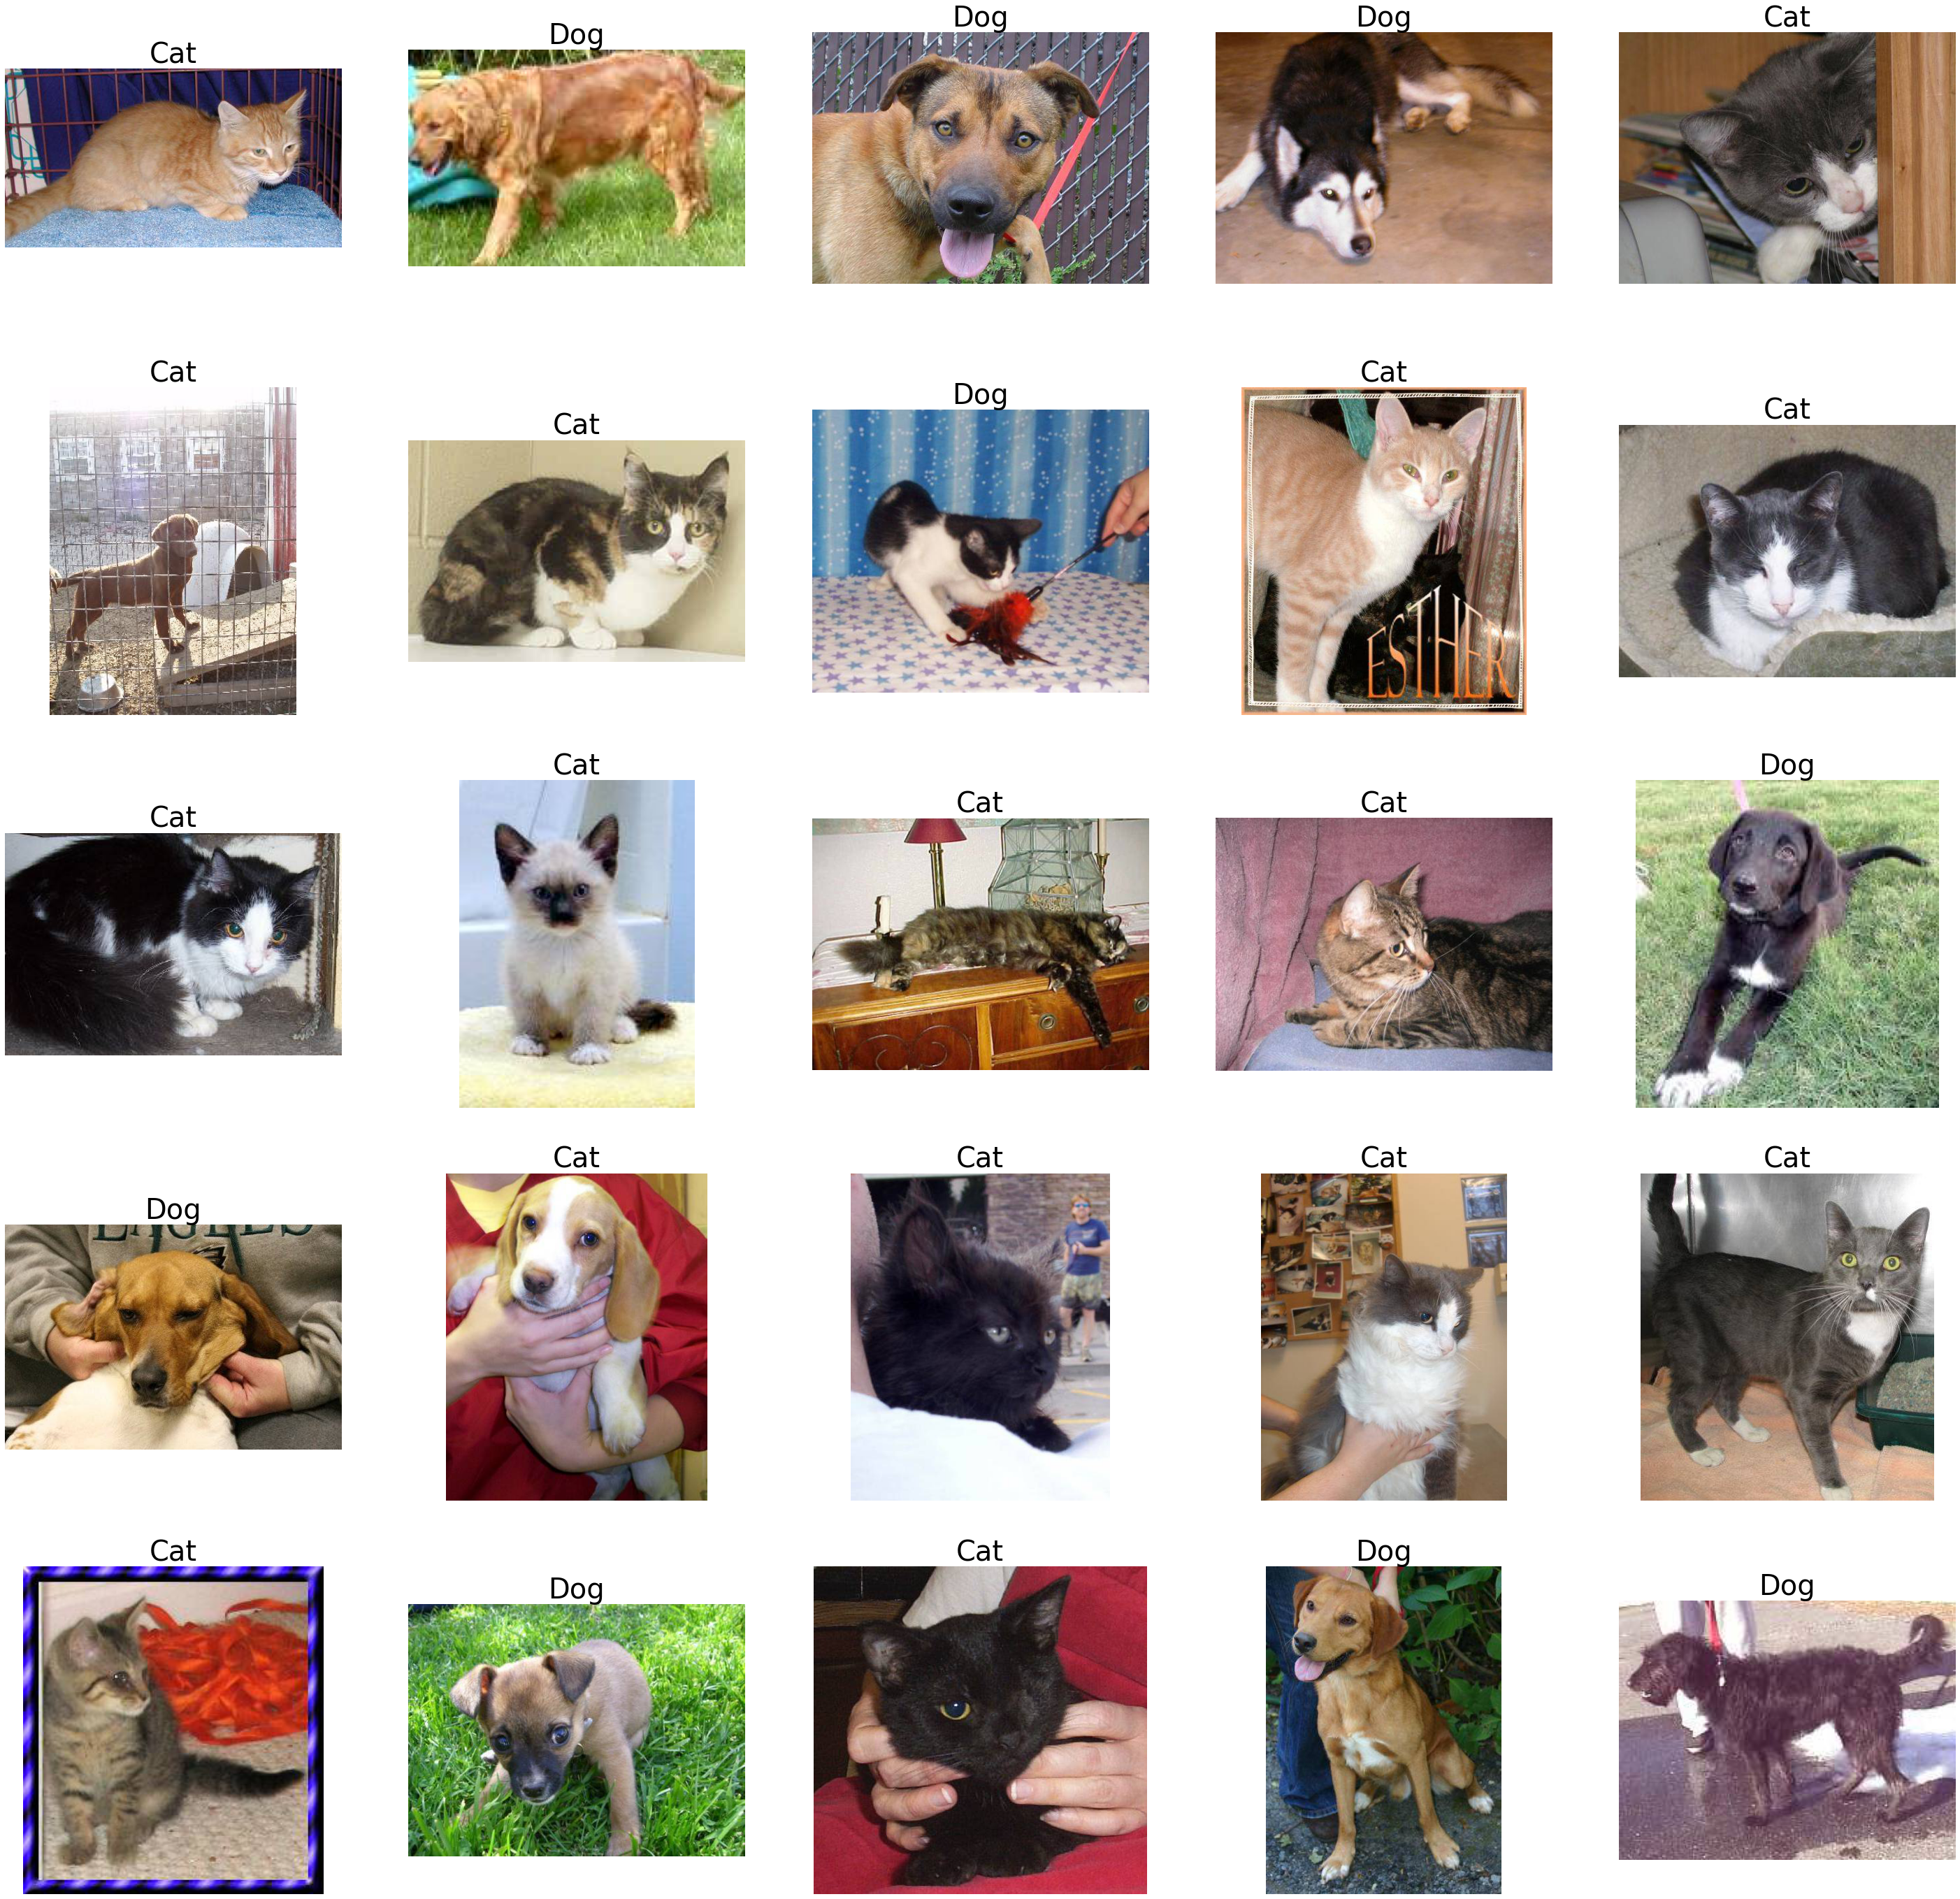

In [ ]:
#Plotting some predictions from the test set
random.shuffle(test_images_folder)

#plotting some images and their predictions
 
fig, axes = plt.subplots(5, 5, figsize = (50, 50))
index = 0
for ax in axes:
  for img, a in zip(full_image_paths[index:index+5], ax):
    label = get_prediction(img)
    img = mpimg.imread(img)
    a.imshow(img)
    a.set_title(label,fontsize = 40)
    a.axis('Off')
  index = index +5
plt.show()